In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from torchvision.transforms import ToTensor, ToPILImage
from PIL import Image

from model import *
from train import *

import os
import shutil
import pickle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device = {device}')

device = cpu


# Load image

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:149: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


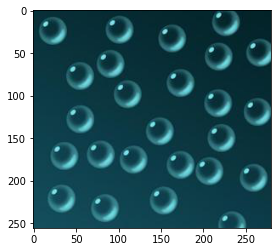

In [4]:
template_name = 'bubbles'

templatePIL = plt.imread(f'images/{template_name}.jpg')
template = ToTensor()(templatePIL).to(device)

plt.imshow(templatePIL)

# Train automaton

In [17]:
automaton = CAutomaton(bias=True, with_first_order=True)
set_perception_kernels(automaton)
initialize_to_zero(automaton)

automaton.to(device)

print(automaton)

CAutomaton(
  (perception_filter): Conv2d(12, 48, kernel_size=(3, 3), stride=(1, 1))
  (update_rule): Sequential(
    (0): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(96, 12, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
)


Epoch 0 complete, loss = 92486.4609375
Epoch 100 complete, loss = 62632.2265625
Epoch 200 complete, loss = 46576.25390625
Epoch 300 complete, loss = 32294.32421875
Epoch 400 complete, loss = 31392.7421875
Epoch 500 complete, loss = 39120.36328125
Epoch 600 complete, loss = 26562.2109375
Epoch 700 complete, loss = 29069.947265625
Epoch 800 complete, loss = 25966.654296875
Epoch 900 complete, loss = 30263.392578125
Epoch 1000 complete, loss = 33357.64453125
Epoch 1100 complete, loss = 28253.88671875
Epoch 1200 complete, loss = 31634.388671875
Epoch 1300 complete, loss = 23017.05859375
Epoch 1400 complete, loss = 19575.412109375
Epoch 1500 complete, loss = 20206.958984375
Epoch 1600 complete, loss = 24906.45703125
Epoch 1700 complete, loss = 24076.37890625
Epoch 1800 complete, loss = 17346.884765625
Epoch 1900 complete, loss = 19415.525390625
Epoch 2000 complete, loss = 19778.873046875
Epoch 2100 complete, loss = 19195.91796875
Epoch 2200 complete, loss = 21539.638671875
Epoch 2300 comple

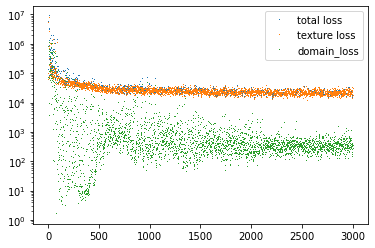

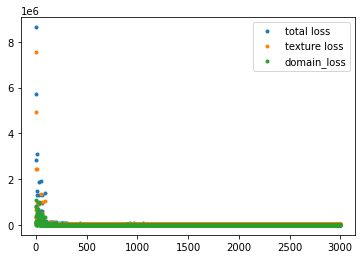

In [18]:
num_epochs = 3000

vgg_mode='mean'

texture_losses, domain_losses, losses = train(automaton, template,
                                              num_epochs=num_epochs,
                                              vgg_mode=vgg_mode)

# plot evolution of loss

plt.semilogy(losses, ',', color='C2', label='total loss')
plt.semilogy(texture_losses, ',', color='C0', label='texture loss')
plt.semilogy(domain_losses, ',', color='C1', label='domain_loss')
plt.legend()
plt.show()

plt.plot(losses[200:], '.', color='C2', label='total loss')
plt.plot(texture_losses[200:], '.', color='C0', label='texture loss')
plt.plot(domain_losses[200:], '.', color='C1', label='domain_loss')
plt.legend()
plt.show()

In [29]:
# save data

if automaton.bias:
    if automaton.with_first_order:
        name = f'{template_name}_bias_order012_{vgg_mode}_{num_epochs}ep'
    else:
        name = f'{template_name}_bias_order02_{vgg_mode}_{num_epochs}ep'
else:
    if automaton.with_first_order:
        name = f'{template_name}_nobias_order012_{vgg_mode}_{num_epochs}ep'
    else:
        name = f'{template_name}_nobias_order02_{vgg_mode}_{num_epochs}ep'

torch.save(automaton.state_dict(), f'pretrained_automata/{name}_state_dict.pt')
with open(f'pretrained_automata/{name}_tlosses.pickle', 'wb') as f:
    pickle.dump(texture_losses, f)
with open(f'pretrained_automata/{name}_dlosses.pickle', 'wb') as f:
    pickle.dump(domain_losses, f)
with open(f'pretrained_automata/{name}_losses.pickle', 'wb') as f:
    pickle.dump(losses, f)

# Test automaton

In [30]:
from torchvision.utils import save_image

if os.path.exists('outputs'):
    shutil.rmtree('outputs')
    os.mkdir('outputs')
else:
    os.mkdir('outputs')

test_iters = 1000

# iterate automaton from random initial state
with torch.inference_mode():
    states = torch.rand((1, automaton.num_states, 128, 128), device=device)
    for step in range(test_iters):
        states = automaton(states)
        img = states[:, :3, :, :]

        save_image(img[0], f'outputs/epoch_{step:05}.png')


In [31]:
# Make a gif animation
def make_gif(test_iters, name):
    frames = [Image.open(f'outputs/epoch_{iter:05}.png') for iter in range(test_iters)]
    frame_one = frames[0]
    frame_one.save(f"gifs/{name}_evolution.gif", format="GIF", append_images=frames,
               save_all=True, duration=10, loop=0)

make_gif(test_iters, name)